In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [2]:
gen32 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen32_sims/data")

In [3]:
X33, y33 = format_data(gen32, 20)
print(X33.shape)
print(y33.shape)

(29688, 20, 2)
(29688, 1)


In [4]:
X33_train, y33_train, X33_test, y33_test = split_data(X33, y33, 0.8)

In [5]:
X33_train, y33_train, X33scale, y33scale = normalise_data(X33_train, y33_train)
X33_test, y33_test, _, _ = normalise_data(X33_test, y33_test)

In [6]:
print(X33scale.mean_)
print(X33scale.var_)
print(y33scale.mean_)
print(y33scale.var_)

[4.72492804 4.79606271]
[0.09182475 0.01743805]
[4.73075553]
[0.09847152]


In [7]:
lstm33=keras.Sequential() #Set up the architecture of the model

lstm33.add(layers.LSTM(units=16, input_shape=(X33_train.shape[1], X33_train.shape[2])))
lstm33.add(layers.Dropout(0.2))

lstm33.add(layers.Dense(units=1))

print(lstm33.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
lstm33.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history33 = lstm33.fit(X33_train, y33_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 19000 samples, validate on 4750 samples
Epoch 1/10
19000/19000 [==============================] - 40s 2ms/sample - loss: 0.1756 - val_loss: 0.0034
Epoch 2/10
19000/19000 [==============================] - 23s 1ms/sample - loss: 0.0415 - val_loss: 0.0031
Epoch 3/10
19000/19000 [==============================] - 22s 1ms/sample - loss: 0.0267 - val_loss: 0.0046
Epoch 4/10
19000/19000 [==============================] - 29s 2ms/sample - loss: 0.0219 - val_loss: 0.0037
Epoch 5/10
19000/19000 [==============================] - 28s 1ms/sample - loss: 0.0234 - val_loss: 0.0072
Epoch 6/10
19000/19000 [==============================] - 25s 1ms/sample - loss: 0.0213 - val_loss: 0.0087
Epoch 7/10
19000/19000 [==============================] - 26s 1ms/sample - loss: 0.0224 - val_loss: 0.0039
Epoch 8/10
19000/19000 [==============================] - 29s 2ms/sample - loss: 0.0239 - val_loss: 0.0087
Epoch 9/10
19000/19000 [==============================] - 26s 1ms/sample - loss: 0.0202 - val_l

In [9]:
lstm33.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm33")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm33/assets


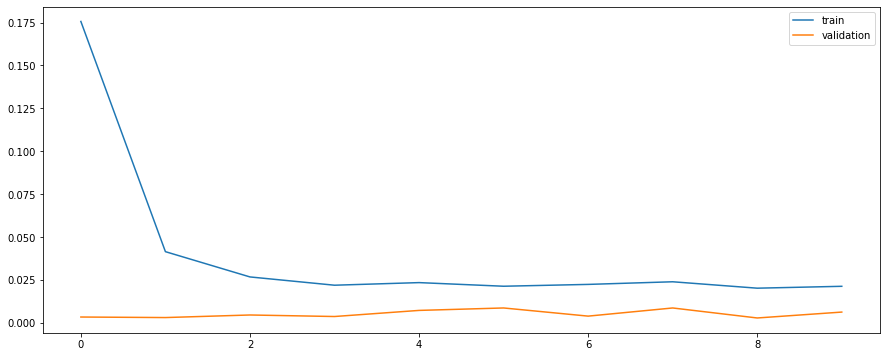

In [10]:
plt.figure(figsize=(15,6))
plt.plot(history33.history["loss"], label="train")
plt.plot(history33.history["val_loss"], label="validation")
plt.legend()

In [11]:
y33_pred = lstm33.predict(X33_test)
y33_train_inv = y33scale.inverse_transform(y33_train.reshape(1, -1))
y33_test_inv = y33scale.inverse_transform(y33_test.reshape(1, -1))
y33_pred_inv = y33scale.inverse_transform(y33_pred)

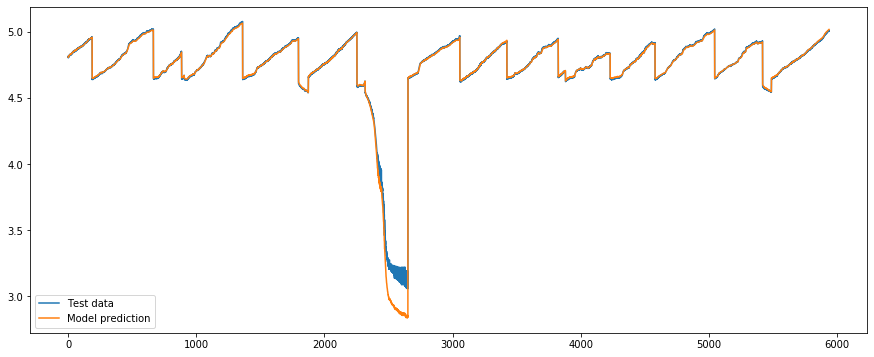

In [12]:
plt.figure(figsize=(15,6))
plt.plot(y33_test_inv.flatten(), label="Test data")
plt.plot(y33_pred_inv.flatten(), label="Model prediction")
plt.legend()